In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
from tqdm import tqdm
from sklearn.gaussian_process.kernels import Matern

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("pdf", "png")
# plt.tight_layout()
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.titlesize"] = 28
plt.rcParams["font.size"] = 28
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 7
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 1.0
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["legend.facecolor"] = "white"
plt.rcParams["axes.labelsize"] = 22
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath, amssymb}']


/var/folders/3t/9g44xm4n6f74bm1skbg0kxdc0000gn/T/ipykernel_11163/1486288270.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("pdf", "png")
/var/folders/3t/9g44xm4n6f74bm1skbg0kxdc0000gn/T/ipykernel_11163/1486288270.py:32: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath, amssymb}']


<font size="5">
    First, we visualize the function.
    $$
    f(x) = \exp \left(\sin \left(C x\right)^2-\|\boldsymbol{x}\|_2^2\right)
    $$
<font>

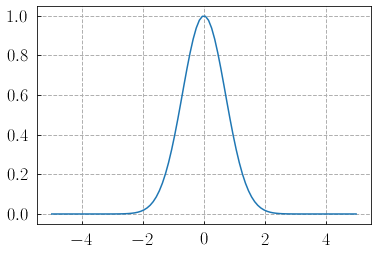

In [26]:
C = 0

x = np.linspace(-5, 5, 100)
fx = np.exp(np.sin(C * x) ** 2 - x ** 2)

plt.figure()
plt.plot(x, fx)
plt.show()

## We try standard Monte Carlo and obtain the true value.

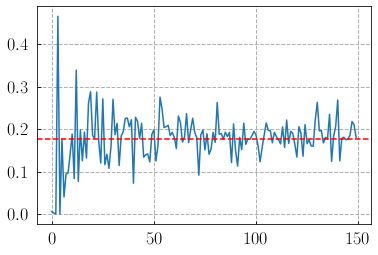

In [27]:
N_max = 150
MC_list = []


for i in range(1, N_max+1):
    x = np.random.uniform(-5.0, 5.0, size = i)
    fx = np.exp(np.sin(C * x) ** 2 - x ** 2)
    MC_list.append(fx.mean())

x = np.random.uniform(-5.0, 5.0, size = 100000)
fx = np.exp(np.sin(C * x) ** 2 - x ** 2)
true_value = fx.mean()

plt.figure()
plt.plot(range(N_max), MC_list)
plt.axhline(y=true_value, linestyle='--', color='r')
plt.show()



## We try Bayesian Monte Carlo.


In [28]:
def Matern_kernel_mean_mean(l):
    part1 = 32 * l / np.sqrt(7) - l ** 2
    part2 = np.exp(-10 * np.sqrt(7) / l)
    part3 = 80 + 200 * np.sqrt(7) / (3 * l) + 38 * l / np.sqrt(7) + l ** 2
    return (part1 + part2 * part3) / 50

def sklearn_Matern(x, y, l):
    ## This is the official Matern kernel in sklearn
    kernel = 1.0 * Matern(length_scale=l, nu=3.5)
    return kernel(x, y)


def Matern_kernel_mean(x, l):
    part3 = np.exp(-np.sqrt(7) * (-x + 5) / l)
    part4 = 48 * l / np.sqrt(7) + 33 * (-x+5) + 9 * np.sqrt(7) * (-x+5) ** 2 / l + 7 * (-x+5) ** 3 / (l ** 2)
    t1 = (16 * l / (5 * np.sqrt(7)) - part3 * part4 / 15) / 10
    part3 = np.exp(-np.sqrt(7) * (x + 5) / l)
    part4 = 48 * l / np.sqrt(7) + 33 * (x+5) + 9 * np.sqrt(7) * (x+5) ** 2 / l + 7 * (x+5) ** 3 / (l ** 2)
    t2 = (16 * l / (5 * np.sqrt(7)) - part3 * part4 / 15) / 10
    return t1 + t2

def BMC_mean_var(x, fx, l, K, Pi_K, Pi_K_K):
    K_inv = np.linalg.inv(K)
    mean = Pi_K.T @ K_inv @ fx
    var = Pi_K_K - Pi_K.T @ K_inv @ Pi_K
    return mean[0], var

    

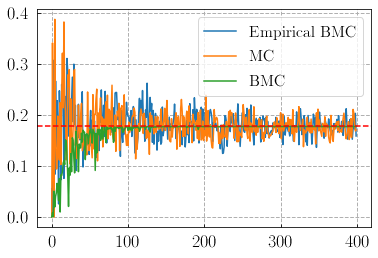

In [29]:
N_max = 400

BMC_list = []
l = 0.2
eps = 1e-6

for i in range(1, N_max+1):
    x = np.random.uniform(-5.0, 5.0, size = i)[:, None]
    fx = np.exp(np.sin(C * x) ** 2 - x ** 2)
    K = sklearn_Matern(x, x, l)
    Pi_K = Matern_kernel_mean(x, l)
    Pi_K_K = Matern_kernel_mean_mean(l)
    K_inv = np.linalg.inv(K + eps * np.eye(i))
    
    mean = (Pi_K.T @ K_inv @ fx).squeeze()
    var = Pi_K_K - Pi_K.T @ K_inv @ Pi_K
    BMC_list.append(mean)


# This is empirical BMC

empirical_BMC_list = []
l = 0.2
eps = 1e-6

for i in range(1, N_max+1):
    x = np.random.uniform(-5.0, 5.0, size = i)[:, None]
    fx = np.exp(np.sin(C * x) ** 2 - x ** 2)
    K = sklearn_Matern(x, x, l)
    
    K_inv = np.linalg.inv(K + eps * np.eye(i))
    Pi_K = K.mean(0)
    Pi_K_K = K.mean()
    
    mean = (Pi_K @ K_inv @ fx).squeeze()
    var = Pi_K_K - Pi_K @ K_inv @ Pi_K.T
    empirical_BMC_list.append(mean)


MC_list = []
for i in range(1, N_max+1):
    x = np.random.uniform(-5.0, 5.0, size = i)
    fx = np.exp(np.sin(C * x) ** 2 - x ** 2)
    MC_list.append(fx.mean())
    
plt.figure()
plt.plot(range(N_max), empirical_BMC_list, label = 'Empirical BMC')
plt.plot(range(N_max), MC_list, label = 'MC')
plt.plot(range(N_max), BMC_list, label = 'BMC')
plt.axhline(y=true_value, linestyle='--', color='r')
plt.legend()
plt.show()

## Next, we try to optimize the length scale with maximizing log-likelihood.

   
## The log-likelihood can be written as:

<font size="5">
$$
\log p(\mathbf{y} \mid X, \boldsymbol{\theta})=-\frac{1}{2} \mathbf{f}^{\top} K^{-1} \mathbf{f}-\frac{1}{2} \log \left|K\right|-\frac{n}{2} \log 2 \pi
$$
<font>

In [6]:
def Matern_kernel(x_tensor, y_tensor, l):
    ## This is Hudson's custom Matern kernel
    r = torch.cdist(x_tensor, y_tensor, p=1)
    part1 = 1 + math.sqrt(7) * r / l + 14 * r ** 2 / (5 * l ** 2) + 7 * math.sqrt(7) * r ** 3 / (15 * l ** 3)
    part2 = torch.exp(-math.sqrt(7) * r / l)
    return part1 * part2

100%|█████████████████████████| 100/100 [00:07<00:00, 13.34it/s]


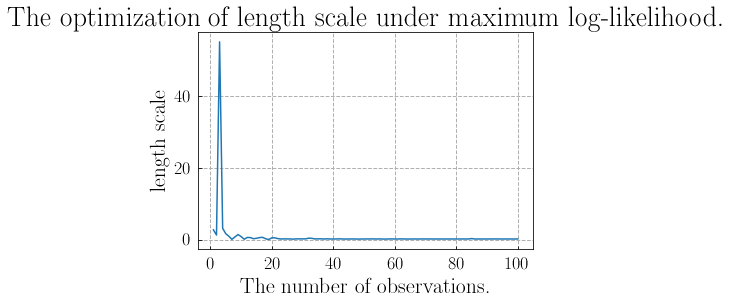

In [9]:
import torch
from torch.autograd import grad
from torch import optim


n_max = 100
l_list = []

for n in tqdm(range(1, n_max+1)):
    x = np.random.uniform(-5.0, 5.0, size = n)[:, None]
    x_tensor = torch.from_numpy(x)
    fx = torch.exp(torch.sin(C * x_tensor) ** 2 - x_tensor ** 2)

    log_l = torch.tensor([1.0], requires_grad=True)
    optimizer = optim.Adam([log_l], lr=0.03)
    eps = 1e-6

    llk_curr = torch.tensor([0.0])
    llk = torch.tensor([1.0])

    while (torch.abs(llk_curr - llk) > 0.001):
        llk_curr = llk
        l = torch.exp(log_l)
        K = Matern_kernel(x_tensor, x_tensor, l)
        K_inv = torch.inverse((K + eps * torch.eye(n)))
        llk = (-0.5 * fx.T @ K_inv @ fx - 0.5 * torch.log(torch.det(K) + eps)) / n
        nll = -llk
        nll.backward()
        optimizer.step()
        # print(llk.detach())
        # print(torch.exp(log_l))
    l_list.append(torch.exp(log_l).detach().numpy())

plt.figure()
plt.plot(range(1, n_max+1), l_list)
plt.title("The optimization of length scale under maximum log-likelihood.")
plt.xlabel("The number of observations.")
plt.ylabel("length scale")
plt.show()

## Now we try to combine the length scale optimization into Bayesian Monte Carlo.

In [10]:

BMC_mean_list = np.zeros(N_max)
BMC_std_list = np.zeros(N_max)
l_list = np.zeros(N_max)
C = 5

for n in tqdm(range(1, N_max+1)):
    x = np.random.uniform(-5.0, 5.0, size = n)[:, None]
    fx = np.exp(np.sin(C * x) ** 2 - x ** 2)
    
    x_tensor = torch.from_numpy(x)
    fx_tensor = torch.exp(torch.sin(C * x_tensor) ** 2 - x_tensor ** 2)
    
    log_l = torch.tensor([1.0], requires_grad=True)
    optimizer = optim.Adam([log_l], lr=0.03)
    eps = 1e-6

    llk_curr = torch.tensor([0.0])
    llk = torch.tensor([1.0])

    while (torch.abs(llk_curr - llk) > 0.001):
        llk_curr = llk
        l = torch.exp(log_l)
        K = Matern_kernel(x_tensor, x_tensor, l)
        K_inv = torch.inverse((K + eps * torch.eye(n)))
        llk = (-0.5 * fx_tensor.T @ K_inv @ fx_tensor - 0.5 * torch.log(torch.det(K) + eps)) / n
        nll = -llk
        nll.backward()
        optimizer.step()
    
    l = torch.exp(log_l).detach().numpy()
    K = sklearn_Matern(x, x, l)
    Pi_K = Matern_kernel_mean(x, l)
    Pi_K_K = Matern_kernel_mean_mean(l)
    mean, var = BMC_mean_var(x, fx, l, K, Pi_K, Pi_K_K)
    BMC_mean_list[n-1] = mean
    BMC_std_list[n-1] = np.sqrt(var[0])
    l_list[n-1] = l



100%|█████████████████████████| 150/150 [00:17<00:00,  8.78it/s]


## Summarize all the plots below.

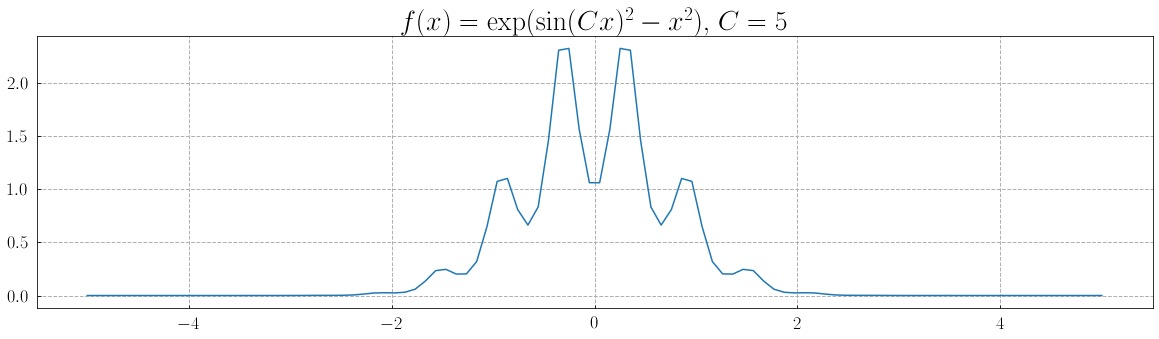

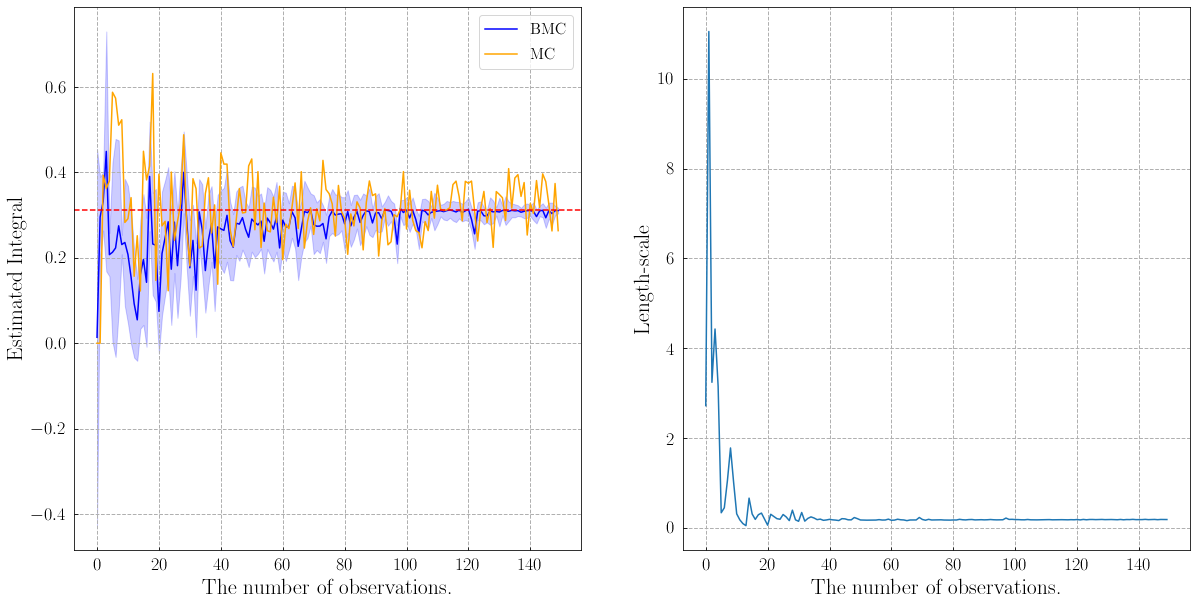

In [11]:
C = 5

x = np.linspace(-5, 5, 100)
fx = np.exp(np.sin(C * x) ** 2 - x ** 2)

plt.figure(figsize=(20, 5))
plt.plot(x, fx)
plt.title(r"$f(x) = \exp (\sin (C x)^2-x^2)$, $C=5$")
plt.show()

fig = plt.figure(figsize=(20, 10))
ax_1, ax_2 = fig.subplots(1, 2)

ax_1.plot(range(N_max), BMC_mean_list, label='BMC', color='blue')
ax_1.fill_between(range(N_max), BMC_mean_list - BMC_std_list, 
                 BMC_mean_list + BMC_std_list, color='blue', alpha=0.2)
ax_1.plot(range(N_max), MC_list, label='MC', color='orange')
ax_1.axhline(y=true_value, linestyle='--', color='r')
ax_1.legend()
ax_1.set_xlabel("The number of observations.")
ax_1.set_ylabel("Estimated Integral")

ax_2.plot(range(N_max), l_list)
ax_2.set_xlabel("The number of observations.")
ax_2.set_ylabel("Length-scale")

plt.show()

In [12]:
l_list

array([ 2.71828175, 11.05331039,  3.23806977,  4.42576933,  3.1521647 ,
        0.33220488,  0.44327697,  1.04595971,  1.77601111,  1.01426148,
        0.30845594,  0.17538922,  0.09125534,  0.04471833,  0.658099  ,
        0.30422723,  0.18451212,  0.2882725 ,  0.32520452,  0.19099951,
        0.05509233,  0.29824203,  0.25055617,  0.20052145,  0.18765338,
        0.29337659,  0.23910299,  0.15727013,  0.39016241,  0.17444545,
        0.14201888,  0.33848   ,  0.14564835,  0.20708302,  0.24023554,
        0.21520042,  0.17866543,  0.19085878,  0.1641489 ,  0.17194407,
        0.1857824 ,  0.17424361,  0.16839533,  0.15882079,  0.20075028,
        0.19614336,  0.17526788,  0.17397252,  0.22619632,  0.20062232,
        0.17128602,  0.16823027,  0.16737705,  0.16839942,  0.16950713,
        0.16985519,  0.1791493 ,  0.17010996,  0.17099525,  0.1898821 ,
        0.16512978,  0.16893145,  0.18833697,  0.17599055,  0.17202014,
        0.15663914,  0.17100732,  0.1725807 ,  0.17214237,  0.22